---
# Система реализации

In [1]:
from typing import List, Dict, NoReturn, Union
import logging
import pandas as pd
import os
import random
import copy
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from category_encoders import CatBoostEncoder

from space_bandits import LinearBandits

from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import sidetable
from pylab import rcParams

%matplotlib inline
matplotlib.rc('figure', figsize=(15, 4))

import warnings

pd.options.display.max_colwidth = 200
warnings.filterwarnings("ignore")

logging.basicConfig(format="%(asctime)s - [%(levelname)s] -  %(funcName)s - %(message)s",
                    datefmt="%d/%m/%Y %H:%M:%S",
                    level=logging.INFO)
logger = logging.getLogger('MAIN')

SEED = 42

In [2]:
def seed_torch(seed: int) -> NoReturn:
    
    """
    Функция, которая фиксирует случайность для дальнейшего воспроизведения кода
    params:
        seed: значение зерна фиксации
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_torch(SEED)

In [3]:
def get_rewards(df, action_name: str, penalty: int=-10) -> List:
    '''
    Функция, которая рассчитывает reward (вознаграждение) по клиенту
        action_name: действие, где 1 - открываем счет, 0 - не открываем счет
    '''
    
    if df[action_name]==0: # если не открываем то список из действий и их наград [0,1] -> [0, penalty]
        return [0, penalty]
    else: 
        return [0, 1] # если открываем то список из действий и их наград [0, 1] -> [0, 1]

In [4]:
### Предобработчик признаков

class SentColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns: list=None) -> None:
        self.columns = columns
    
    def fit(self, X:pd.DataFrame=None, y:pd.DataFrame=None):
        return self

    def transform(self, X:pd.DataFrame=None)->pd.DataFrame:
        df_x = pd.DataFrame(X)
        df_x.columns = self.columns
        return df_x
    
def base_pipe(num_columns:list=None, cat_columns:list=None, fill_value:float=-1e24)->object:

    # создаем конвейер для количественных переменных
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value = fill_value)),
        ('scaler', StandardScaler())
    ])

    # создаем конвейер для категориальных переменных
    cat_pipe = Pipeline([
        ('catenc', CatBoostEncoder(cols=cat_columns))
    ])

    transformers = [('num', num_pipe, num_columns),
                    ('cat', cat_pipe, cat_columns)]

    # передаем список трансформеров в ColumnTransformer
    transformer = ColumnTransformer(transformers=transformers)

    # задаем итоговый конвейер
    prep_pipe = Pipeline([
        ('transform', transformer),
        ('sent_columns', SentColumns(columns=num_columns+cat_columns))
    ])  

    return prep_pipe

In [5]:
df = pd.read_csv("./data/df_train.csv")
print(df.shape)
print(df.target.mean())
df.head(2)

(52049, 83)
0.11297047013391227


,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,NaN,0,0,0,1,2,4,4,3,1
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,NaN,0,2,1,0,0,1,0,0,5


In [6]:
with open(r'./data/features.yaml', 'r') as f:
    dict_features = yaml.load(f, Loader=yaml.Loader)
num_cols = dict_features['cont_features']
cat_cols = dict_features['cat_features']

feat_cols = num_cols+cat_cols

print(len(num_cols),len(cat_cols))

16 24


In [7]:
data_prepared = base_pipe(num_columns=num_cols,
                          cat_columns=cat_cols).fit_transform(df,
                                                              df["target"]).reset_index(drop=True)
df[num_cols+cat_cols] = data_prepared[num_cols+cat_cols]
df.head(2)

,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,-0.395848,0.112970,0,0,0.11297,2,4,4,0.11297,0.11297
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,-0.395848,0.056485,2,1,0.11297,0,1,0,0.11297,0.11297


In [8]:
df['best_action'] = np.where(df.target==1, 0, 1)
df['rewards'] = df.apply(lambda x: get_rewards(df=x, action_name='best_action', penalty=-3), axis=1)

In [9]:
context = ['indeks_finansovogo_riska', 'kod_osnovnogo_okved', 'data_registratsii','sub_ekt_mestonahozhdenija']
action_name = 'best_action'
reward_name = 'rewards'

In [10]:
df = df[context+["target"]+[action_name]+[reward_name]]
print(df.shape)
df.head()

(52049, 7)


,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija,target,best_action,rewards
0,0.112970,0.11297,0.112970,0.11297,0,1,"[0, 1]"
1,0.112970,0.11297,0.112970,0.11297,0,1,"[0, 1]"
2,0.056485,0.11297,0.112970,0.11297,0,1,"[0, 1]"
3,0.112970,0.11297,0.112970,0.11297,0,1,"[0, 1]"
4,0.056485,0.11297,0.056485,0.11297,1,0,"[0, -3]"


In [11]:
from space_bandits import LinearBandits

In [12]:
num_actions = df[action_name].nunique()
num_features = len(context)
linearb_model = LinearBandits(num_actions=num_actions, 
                              num_features=num_features, 
                              initial_pulls=100)

In [13]:
train, valid = train_test_split(df, test_size=0.25, random_state=SEED)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print(train.shape, valid.shape)

(39036, 7) (13013, 7)


In [14]:
def make_plots(history: Dict):
    plt.plot(history['cumulative_reward_list'], label = 'Reward total', c = 'red')
    plt.plot(history['cumulative_regret_list'], label = 'Regret total', c = 'blue')
    plt.title("Эволюция общей суммы Reward и Regred")
    plt.legend()
    plt.grid()

In [15]:
class MBanditsSystem:
    def __init__(self, action_name: str, reward_name: str, coef: float):
        
        '''
        Класс UcbBanditsSystem системы обучения по батчам и дообучения
            action_name: столбец действия/ руки
            reward_name: столбец награды/ ответа
            coef: параметр исследования
        '''
        
        self.action_name = action_name
        self.reward_name = reward_name
        self.coef = coef
        
        self.cnt = 0
        
    def train(self, df: pd.DataFrame, random: bool=False, reset: bool=False):
        
        '''
        Функция обучения
            df: датафрейм с контекстом, действиями и наградой
            random: параметр модели случайная / UCB
        '''
        history = {'cumulative_reward_list': list(),
                   'cumulative_regret_list': list()}
        
        # общее вознаграждение и упущенная возможность
        self.cumulative_reward, self.total_regret = 0, 0
        
        n_arms = df[self.action_name].nunique()
        arm_indices = np.array(range(n_arms))
        
        # среднее вознаграждение за каждую руку
        self.Q = np.zeros(n_arms)
        # критерий неопределенности UCB
        self.uncertainty = np.zeros(n_arms)
        # количество шагов для каждой руки
        self.N = np.zeros(n_arms)
        
        if reset:
            self.cnt = 0
        
        # итерируемся по обчающему множеству
        for indx, row in tqdm(df.iterrows()):
            
            if random:
                arm = np.random.choice(arm_indices)
            else:
                # выбор руки
                if any(self.N==0):
                    arm = np.random.choice(arm_indices[self.N==0])
                else:
                    uncertainty = np.sqrt(np.log(self.cnt) / self.N)
                    arm = np.argmax(self.Q +  self.coef * self.uncertainty)

            self.cnt += 1
            
            #### Надо задать конверсии (мб через бернулливскую величину)
            # ЭКСПЕРИМЕНТ№1: 2%,4%,6% конверсии, награды одинаковы
            # ЭКСПЕРИМЕНТ№2: 2%,4%,6% конверсии, награды 6,4,2
            # ЭКСПЕРИМЕНТ№3: 2%,4%,6% конверсии, поменялись награды в середине (сначала одинаковы, потом 6,4,2)
            
            
            ### НУЖНО ПОКУМЕКАТЬ... (что если у нас нет никакой информации о том какая рука оптимальная и какая награда для каждой из рук...)
            reward = row[self.reward_name][arm]
        
            mx = row[self.reward_name][row[self.action_name]]
            
            self.N[arm] += 1
            self.Q[arm] += (1 / self.N[arm]) * (reward - self.Q[arm])
            
            
            # считаем вознаграждение, упущенную возможность и добавляем к накопительным спискам
            regret = mx - reward
            self.total_regret += regret
            history['cumulative_regret_list'].append(self.total_regret)
            self.cumulative_reward += reward
            history['cumulative_reward_list'].append(self.cumulative_reward)
        
        if random:
            self.bandit = None
        else:
            self.bandit = {'Q':self.Q,'uncertainty':self.uncertainty,'N':self.N}
                    
        return self.bandit, history
    
    def fine_train(self, pre_train_bandit, df: pd.DataFrame):
        
        '''
        Функция дообучения
            df: датафрейм с контекстом, действиями и наградой
        '''
        history_fine = {'cumulative_reward_list': list(),
                        'cumulative_regret_list': list()}
        
        cumulative_reward, total_regret = self.cumulative_reward, self.total_regret
        
        bandit = copy.deepcopy(pre_train_bandit)
        
        n_arms = df[self.action_name].nunique()
        arm_indices = np.array(range(n_arms))
        
        fine_cnt = self.cnt
        
        if bandit is None:
            logger.error('Дообучение доступно только для UCB алгоритма!')
            return None, None
        
        else:

            for indx_update, row_update in df.iterrows():

                # выбор руки
                if any(bandit['N']==0):
                    arm = np.random.choice(arm_indices[bandit['N']==0])
                else:
                    bandit['uncertainty'] = np.sqrt(np.log(fine_cnt) / bandit['N'])
                    arm = np.argmax(bandit['Q'] +  self.coef * bandit['uncertainty'])
            
                fine_cnt += 1
                
                reward = row_update[self.reward_name][arm]

                mx = row_update[self.reward_name][row_update[self.action_name]]

                bandit['N'][arm] += 1
                bandit['Q'][arm] += (1 / bandit['N'][arm]) * (reward - bandit['Q'][arm])

                # считаем вознаграждение, упущенную возможность и добавляем к накопительным спискам
                regret = mx - reward
                total_regret += regret
                history_fine['cumulative_regret_list'].append(total_regret)
                cumulative_reward += reward
                history_fine['cumulative_reward_list'].append(cumulative_reward)
        
            logger.info(f'Было дообучено {fine_cnt-self.cnt} клиентов к {self.cnt}, итого UCB алгоритм обучен на {fine_cnt} клиентах!')
            
            return bandit, history_fine    

In [16]:
mabmodel = MBanditsSystem(action_name=action_name,
                          reward_name=reward_name,
                          coef=10)

In [17]:
random_bandit_model, random_history = mabmodel.train(df=train, random=True, reset=True)
random_bandit_model

39036it [00:04, 9397.02it/s]


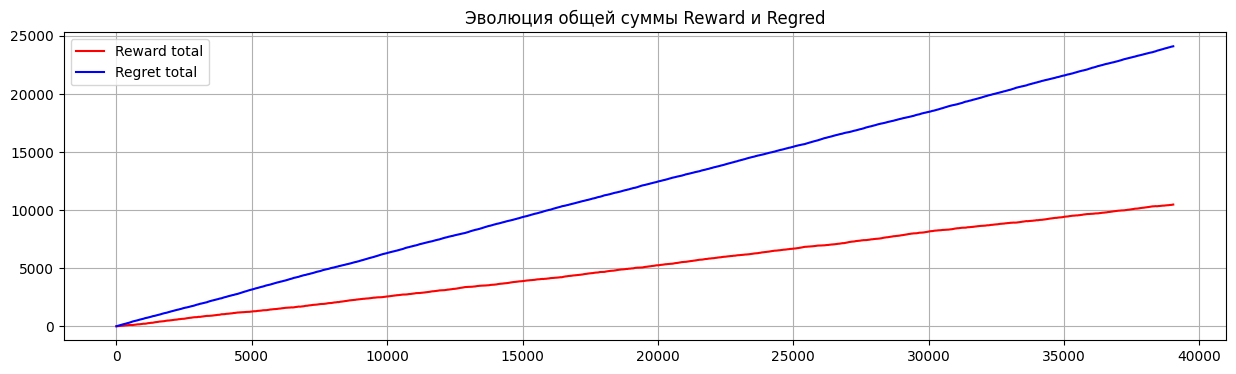

In [18]:
make_plots(random_history)

---
# UCB

In [19]:
ucb_bandit_model, ucb_history = mabmodel.train(df=train, reset=True)

39036it [00:04, 9387.07it/s] 


In [20]:
ucb_bandit_model

{'Q': array([ 0.        , -0.33333333]),
 'uncertainty': array([0., 0.]),
 'N': array([3.903e+04, 6.000e+00])}

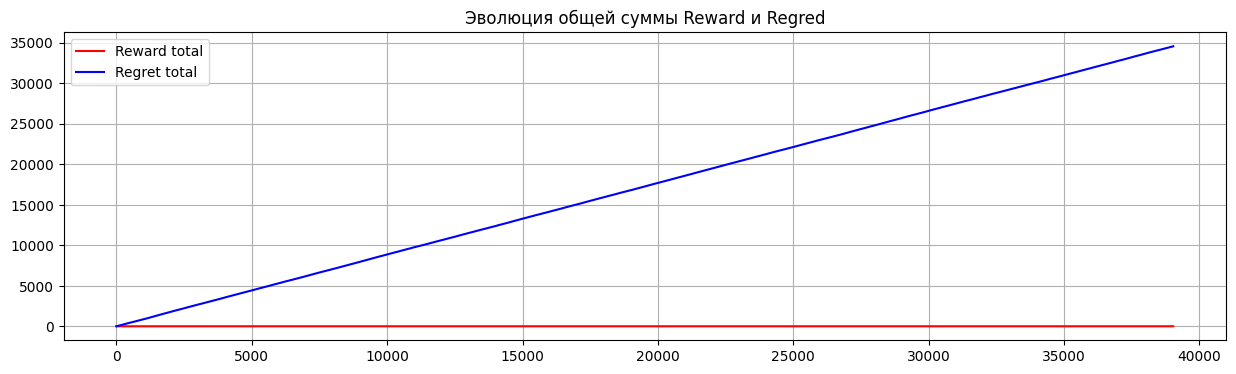

In [21]:
make_plots(ucb_history)

In [22]:
width = 0.45
bins = np.linspace(0, num_actions-1, num_actions) - width/2

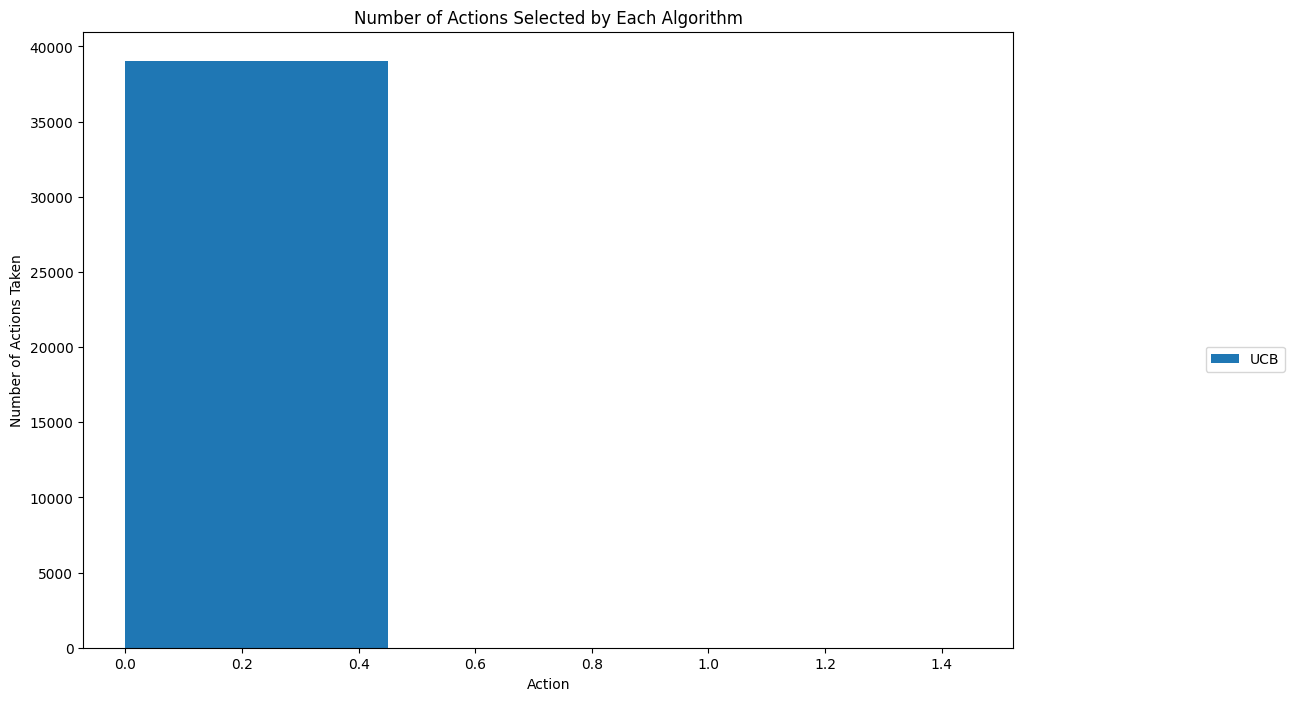

In [23]:
plt.figure(figsize=(12,8))
plt.bar(bins+0.45, ucb_bandit_model['N'],
        width=width, 
        label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title("Number of Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

In [24]:
ucb_bandit_fine_model, ucb_fine_history = mabmodel.fine_train(df=valid, pre_train_bandit=ucb_bandit_model)

09/08/2024 17:14:12 - [INFO] -  fine_train - Было дообучено 13013 клиентов к 39036, итого UCB алгоритм обучен на 52049 клиентах!


In [25]:
ucb_bandit_fine_model

{'Q': array([0.        , 0.57016668]),
 'uncertainty': array([0.01668069, 0.02888293]),
 'N': array([39030., 13019.])}

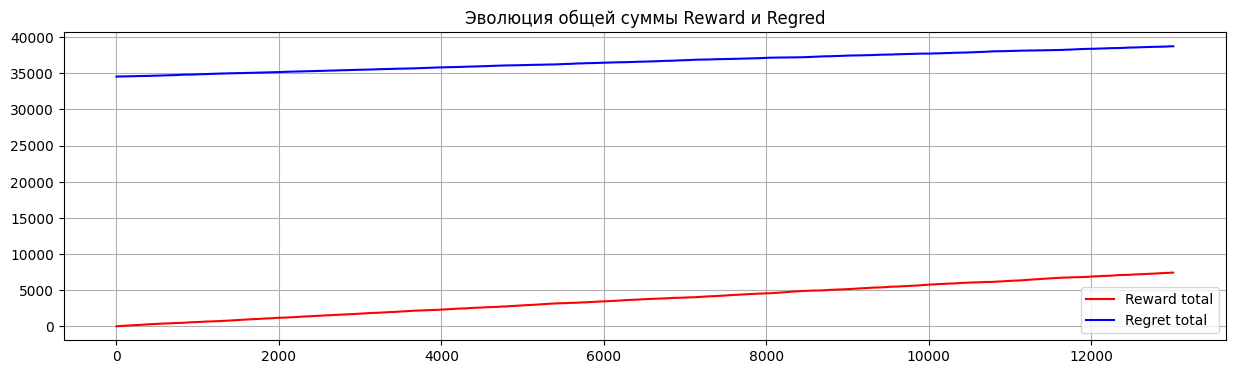

In [26]:
make_plots(ucb_fine_history)

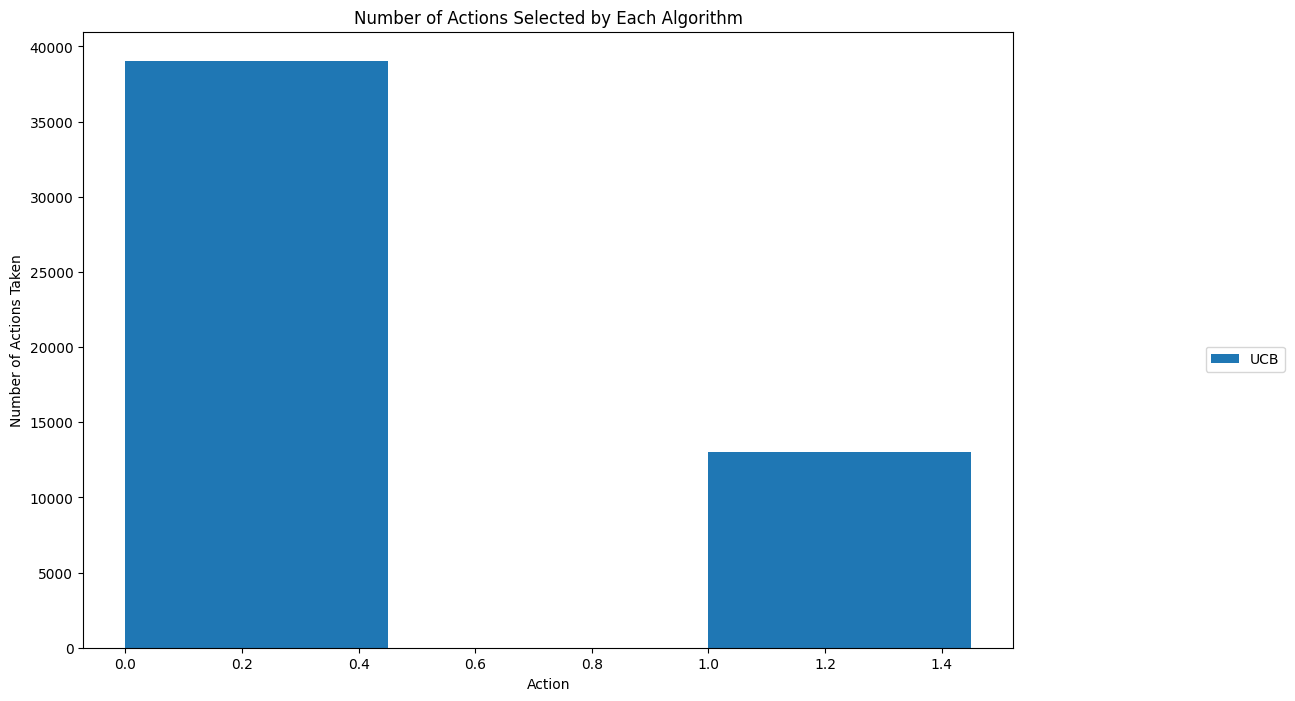

In [27]:
plt.figure(figsize=(12,8))
plt.bar(bins+0.45, ucb_bandit_fine_model['N'],
        width=width, 
        label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title("Number of Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

In [28]:
from collections import Counter

class LinearBanditsSystem:
    def __init__(self, bandit_model, context_list: List, action_name: str, reward_name: str):
        
        '''
        Класс LinearBanditsSystem системы обучения по батчам и дообучения
            bandit_model: объект бандита из Space Bandits
            context_list: список фичей для контекста
            action_name: столбец действия/ руки
            reward_name: столбец награды/ ответа
        '''
        
        self.bandit = bandit_model
        self.context_list = context_list
        self.action_name = action_name
        self.reward_name = reward_name
        
        self.num_actions = bandit_model.hparams['num_actions']
        self.cnt = 0
        
    def train(self, df: pd.DataFrame, first_batch_size: int, retrain: bool = False):
        
        '''
        Функция обучения
            df: датафрейм с контекстом, действиями и наградой
            first_batch_size: размер батча обучения
        '''
        history = {'cumulative_reward_list': list(),
                   'cumulative_regret_list': list()}
        
        X, y, a = list(), list(), list()
        
        # общее вознаграждение и упущенная возможность
        self.cumulative_reward, self.total_regret = 0, 0
        
        # итерируемся по обчающему множеству
        for indx, row in tqdm(df.iterrows()):
            
            # достаем контекст по клиенту
            context = np.array([row[self.context_list]])
            
            # условие накопления данных, установлен размер first_batch_size
            if (self.cnt+1) < first_batch_size:
                # пока не накопили данные - дергаем ручку случайно из array действий
                arm = np.random.choice(np.array(range(self.num_actions)))
            else:
                # как только накопили случайные действия, начинаем принимать решения относительно знаний бандита
                arm = self.bandit.action(context)
            self.cnt += 1
            
            # если действие не равно оптимальному - получаем нулевое вознаграждение, в остальных случаях берем наилучшее вознаграждение
            
            reward = float(row[self.reward_name][arm])

            mx = row[self.reward_name][row[self.action_name]]
            
            # добавляем к выборке всех проверенных клиентов
            X.append(context.tolist()[0])
            y.append(reward)
            a.append(arm)
            
            # считаем вознаграждение, упущенную возможность и добавляем к накопительным спискам
            regret = mx - reward
            self.total_regret += regret
            history['cumulative_regret_list'].append(self.total_regret)
            self.cumulative_reward += reward
            history['cumulative_reward_list'].append(self.cumulative_reward)
            
            # как только изучили first_batch_size клиентов, обновляем и обучаем бандита
            if self.cnt % first_batch_size == 0:
                logger.info(msg=f'Обновление модели на подвыборке {self.cnt}')
                train_df = pd.DataFrame(X,
                                        columns=self.context_list)
                train_df[self.reward_name] = y
                train_df[self.action_name] = a
                logger.info(msg=f'Распределение ручек: \n{train_df[self.action_name].value_counts()}')
                logger.info(msg=f'Текущий regret: {history["cumulative_regret_list"][-1]}')

                for indx_update, row_update in train_df.iterrows():
                    context = np.array([row_update[self.context_list]])
                    action = int(row_update[self.action_name])
                    reward = float(row_update[self.reward_name])
                    self.bandit.update(context, action, reward)
                    
                if retrain:
                    X, y, a = list(), list(), list()
                    
        return self.bandit, history
                    
    def fine_train(self, pre_train_bandit, df: pd.DataFrame):
        
        '''
        Функция дообучения
            df: датафрейм с контекстом, действиями и наградой
        '''
        history_fine = {'cumulative_reward_list': list(),
                        'cumulative_regret_list': list()}
        
        a = list()
        
        cumulative_reward, total_regret = self.cumulative_reward, self.total_regret
        
        bandit = copy.deepcopy(pre_train_bandit)

        for indx_update, row_update in tqdm(df.iterrows()):
            
            context = np.array([row_update[self.context_list]])
            action = int(row_update[self.action_name])
            
            arm = bandit.action(context)
            reward = float(row_update[self.reward_name][arm])
            bandit.update(context, action, reward)
            
            a.append(arm)
            
            mx = row_update[self.reward_name][row_update[self.action_name]]
            
            # считаем вознаграждение, упущенную возможность и добавляем к накопительным спискам
            regret = mx - reward
            total_regret += regret
            history_fine['cumulative_regret_list'].append(total_regret)
            cumulative_reward += reward
            history_fine['cumulative_reward_list'].append(cumulative_reward)
        logger.info(msg=f'Распределение ручек после дообучения: \n{Counter(a)}')
        
        return bandit, history_fine

In [29]:
model = LinearBanditsSystem(bandit_model=linearb_model,
                            context_list=context,
                            action_name=action_name,
                            reward_name=reward_name
                           )

In [30]:
base_bandit_model, train_history = model.train(df=train,
                                               first_batch_size=5_000,
                                               retrain=True
                                              )

4969it [00:03, 1771.38it/s]09/08/2024 17:14:25 - [INFO] -  train - Обновление модели на подвыборке 5000
09/08/2024 17:14:25 - [INFO] -  train - Распределение ручек: 
0    2505
1    2495
Name: best_action, dtype: int64
09/08/2024 17:14:25 - [INFO] -  train - Текущий regret: 3094.0
9934it [00:13, 886.65it/s] 09/08/2024 17:14:36 - [INFO] -  train - Обновление модели на подвыборке 10000
09/08/2024 17:14:36 - [INFO] -  train - Распределение ручек: 
1    4473
0     527
Name: best_action, dtype: int64
09/08/2024 17:14:36 - [INFO] -  train - Текущий regret: 4570.0
14995it [00:28, 1017.68it/s]09/08/2024 17:14:50 - [INFO] -  train - Обновление модели на подвыборке 15000
09/08/2024 17:14:50 - [INFO] -  train - Распределение ручек: 
1    4527
0     473
Name: best_action, dtype: int64
09/08/2024 17:14:50 - [INFO] -  train - Текущий regret: 6145.0
19996it [00:45, 874.77it/s] 09/08/2024 17:15:07 - [INFO] -  train - Обновление модели на подвыборке 20000
09/08/2024 17:15:07 - [INFO] -  train - Распреде

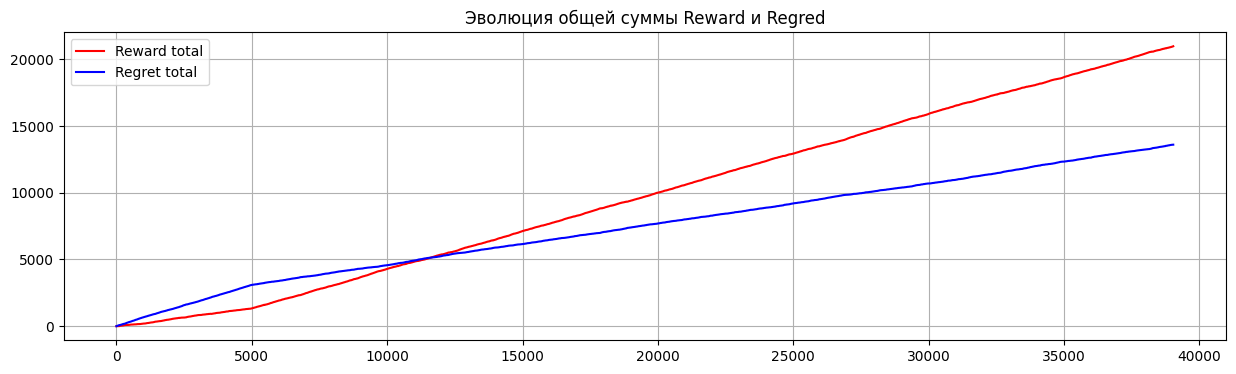

In [31]:
make_plots(train_history)

---
# Модель обучена
### Применим на валидационной выборке
* Отдаем выборку с действиями заказчику

In [32]:
from sklearn.metrics import classification_report

In [33]:
valid, control = train_test_split(valid, test_size=0.5)
valid.reset_index(drop=True, inplace=True)
control.reset_index(drop=True, inplace=True)
print(valid.shape, control.shape)

(6506, 7) (6507, 7)


In [34]:
model.context_list

['indeks_finansovogo_riska',
 'kod_osnovnogo_okved',
 'data_registratsii',
 'sub_ekt_mestonahozhdenija']

In [35]:
valid[model.context_list].head()

,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija
0,0.082579,0.051883,0.204382,0.070432
1,0.084568,0.194802,0.094742,0.122519
2,0.212799,0.004912,0.047387,0.164280
3,0.010754,0.000573,0.034050,0.005135
4,0.035670,0.037657,0.039536,0.002973


In [36]:
valid_to_bussines = valid.copy()
valid_to_bussines.head()

,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija,target,best_action,rewards
0,0.082579,0.051883,0.204382,0.070432,1,0,"[0, -3]"
1,0.084568,0.194802,0.094742,0.122519,0,1,"[0, 1]"
2,0.212799,0.004912,0.047387,0.164280,0,1,"[0, 1]"
3,0.010754,0.000573,0.034050,0.005135,0,1,"[0, 1]"
4,0.035670,0.037657,0.039536,0.002973,1,0,"[0, -3]"


In [37]:
valid_to_bussines = valid.copy()
for a, vals in enumerate(base_bandit_model.expected_values(valid_to_bussines[model.context_list])):
    valid_to_bussines[f'm0_action_{a}'] = vals
valid_to_bussines['best_action_m0'] = valid_to_bussines[[f'm0_action_{a}' for a in range(num_actions)]].idxmax(axis=1)  
valid_to_bussines['best_action_m0'] = valid_to_bussines['best_action_m0'].apply(lambda x: int(x[-1]))
valid_to_bussines.head()

,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija,target,best_action,rewards,m0_action_0,m0_action_1,best_action_m0
0,0.082579,0.051883,0.204382,0.070432,1,0,"[0, -3]",0.0,0.453214,1
1,0.084568,0.194802,0.094742,0.122519,0,1,"[0, 1]",0.0,0.233028,1
2,0.212799,0.004912,0.047387,0.164280,0,1,"[0, 1]",0.0,0.420464,1
3,0.010754,0.000573,0.034050,0.005135,0,1,"[0, 1]",0.0,0.991308,1
4,0.035670,0.037657,0.039536,0.002973,1,0,"[0, -3]",0.0,0.846831,1


In [38]:
valid_to_bussines[['best_action','best_action_m0']].corr()

,best_action,best_action_m0
best_action,1.000000,0.223237
best_action_m0,0.223237,1.000000


In [39]:
print(classification_report(valid_to_bussines.best_action,valid_to_bussines.best_action_m0))

              precision    recall  f1-score   support

           0       0.33      0.26      0.29       684
           1       0.92      0.94      0.93      5822

    accuracy                           0.87      6506
   macro avg       0.62      0.60      0.61      6506
weighted avg       0.85      0.87      0.86      6506



---
# Полчили ответы от заказчика 
### Применим на контрольной выборке
* Отдаем новую выборку с действиями заказчику

In [40]:
fine_bandit_model, fine_train_history = model.fine_train(pre_train_bandit=base_bandit_model, df=valid)

6506it [00:44, 146.80it/s]
09/08/2024 17:19:19 - [INFO] -  fine_train - Распределение ручек после дообучения: 
Counter({1: 6205, 0: 301})


In [41]:
for a, vals in enumerate(fine_bandit_model.expected_values(valid_to_bussines[model.context_list])):
    valid_to_bussines[f'm1_action_{a}'] = vals
valid_to_bussines['best_action_m1'] = valid_to_bussines[[f'm1_action_{a}' for a in range(num_actions)]].idxmax(axis=1)  
valid_to_bussines['best_action_m1'] = valid_to_bussines['best_action_m1'].apply(lambda x: int(x[-1]))
valid_to_bussines.head()

,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija,target,best_action,rewards,m0_action_0,m0_action_1,best_action_m0,m1_action_0,m1_action_1,best_action_m1
0,0.082579,0.051883,0.204382,0.070432,1,0,"[0, -3]",0.0,0.453214,1,-0.493049,0.539900,1
1,0.084568,0.194802,0.094742,0.122519,0,1,"[0, 1]",0.0,0.233028,1,-0.346234,0.365271,1
2,0.212799,0.004912,0.047387,0.164280,0,1,"[0, 1]",0.0,0.420464,1,-0.284881,0.526634,1
3,0.010754,0.000573,0.034050,0.005135,0,1,"[0, 1]",0.0,0.991308,1,-0.472598,0.985925,1
4,0.035670,0.037657,0.039536,0.002973,1,0,"[0, -3]",0.0,0.846831,1,-0.421046,0.871272,1


In [42]:
valid_to_bussines.best_action.value_counts()

1    5822
0     684
Name: best_action, dtype: int64

In [43]:
valid_to_bussines.best_action_m0.value_counts()

1    5974
0     532
Name: best_action_m0, dtype: int64

In [44]:
valid_to_bussines.best_action_m1.value_counts()

1    6326
0     180
Name: best_action_m1, dtype: int64

In [45]:
valid_to_bussines[['best_action','best_action_m0','best_action_m1']].corr()

,best_action,best_action_m0,best_action_m1
best_action,1.000000,0.223237,0.156051
best_action_m0,0.223237,1.000000,0.565260
best_action_m1,0.156051,0.565260,1.000000


In [46]:
print(classification_report(valid_to_bussines.best_action,valid_to_bussines.best_action_m1))

              precision    recall  f1-score   support

           0       0.39      0.10      0.16       684
           1       0.90      0.98      0.94      5822

    accuracy                           0.89      6506
   macro avg       0.65      0.54      0.55      6506
weighted avg       0.85      0.89      0.86      6506



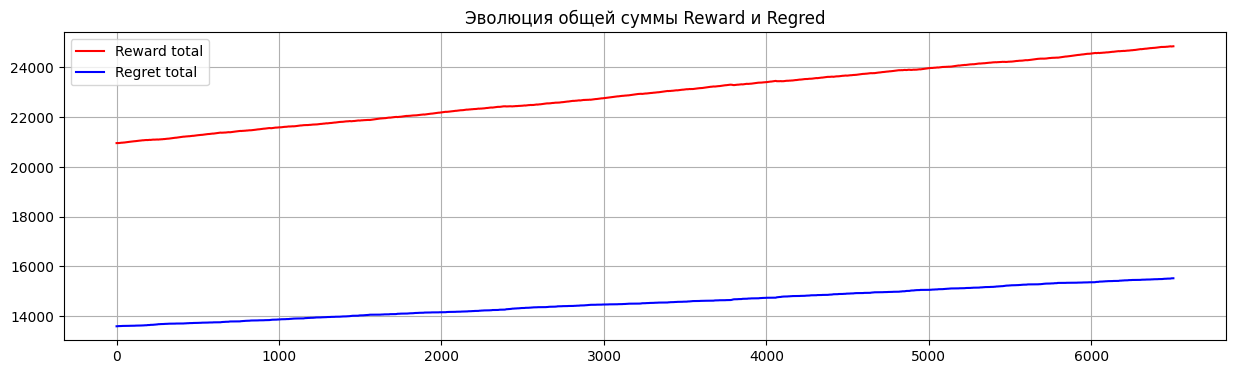

In [47]:
make_plots(fine_train_history)